# Introducción a Pytorch

## Preparación

In [1]:
# !pip install torch torchvision torchaudio scikit-learn  # (si hace falta)
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt

torch.manual_seed(0)  # reproducibilidad

# Datos sintéticos

In [3]:
X, y = make_moons(n_samples=1000, noise=0.2, random_state=0)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=0)

X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)     # CrossEntropyLoss espera long
X_val   = torch.tensor(X_val, dtype=torch.float32)
y_val   = torch.tensor(y_val, dtype=torch.long)


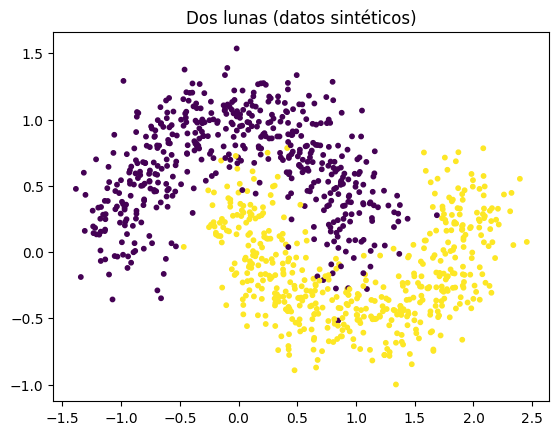

In [4]:
plt.scatter(X[:,0], X[:,1], c=y, s=10)
plt.title("Dos lunas (datos sintéticos)")
plt.show()


# Propagación hacia adelante (forward)

## 1. Forward “a mano” con tensores (ilustra el cálculo)

Definimos pesos aleatorios y aplicamos: X -> capa oculta -> ReLU -> salida (logits).

In [5]:
# Dimensiones
in_features = 2
hidden = 16
out_features = 2  # dos clases

# Inicialización aleatoria (por defecto ~N(0,1) escalado según init de PyTorch si usas nn.Linear;
# aquí lo haremos explícito con torch.randn)
W1 = torch.randn(in_features, hidden, dtype=torch.float32) * 0.1
b1 = torch.zeros(hidden, dtype=torch.float32)

W2 = torch.randn(hidden, out_features, dtype=torch.float32) * 0.1
b2 = torch.zeros(out_features, dtype=torch.float32)

# Forward manual (sin autograd por ahora, solo para ver el paso hacia adelante)
def forward_manual(X):
    z1 = X @ W1 + b1          # capa lineal 1
    h1 = F.relu(z1)           # activación
    logits = h1 @ W2 + b2     # capa lineal 2
    return logits

logits0 = forward_manual(X_train)     # [N, 2]
print("Logits iniciales (primeras 5 filas):\n", logits0[:5])


Logits iniciales (primeras 5 filas):
 tensor([[-0.0003,  0.0152],
        [-0.0175,  0.0288],
        [-0.0013,  0.0677],
        [-0.0200, -0.0194],
        [-0.0052,  0.0584]])


Pérdida inicial

In [6]:
loss_fn = nn.CrossEntropyLoss()
loss0 = loss_fn(logits0, y_train)
print("Pérdida inicial (sin entrenar):", float(loss0))

Pérdida inicial (sin entrenar): 0.6955942511558533


## 2. Forward usando un nn.Module (lo normal en PyTorch)

In [7]:
class MLP(nn.Module):
    def __init__(self, in_features=2, hidden=16, out_features=2):
        super().__init__()
        self.fc1 = nn.Linear(in_features, hidden)  # inicializa pesos aleatoriamente
        self.fc2 = nn.Linear(hidden, out_features)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)  # logits (sin softmax para usar CrossEntropyLoss)
        return x

net = MLP(in_features=2, hidden=16, out_features=2)
logits = net(X_train)           # forward
loss = loss_fn(logits, y_train) # pérdida inicial
print("Pérdida inicial (nn.Module):", float(loss))


Pérdida inicial (nn.Module): 0.6409566402435303


# Propagación hacia atrás y optimización

El ciclo de entrenamiento en PyTorch siempre sigue estos pasos:

1. `optimizer.zero_grad()` — limpiar gradientes acumulados
2. `logits = net(X_batch)` — **forward**
3. `loss = loss_fn(logits, y_batch)` — calcular pérdida
4. `loss.backward()` — **backward** (autograd calcula ∂loss/∂θ)
5. `optimizer.step()` — **actualiza** parámetros con el optimizador

In [8]:
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)  # también puedes usar Adam

def accuracy(model, X, y):
    with torch.no_grad():
        pred = model(X).argmax(dim=1)
        return (pred == y).float().mean().item()

print("Acc (antes):", accuracy(net, X_val, y_val))

for epoch in range(200):
    optimizer.zero_grad()
    logits = net(X_train)
    loss = loss_fn(logits, y_train)
    loss.backward()          # calcula gradientes d(loss)/d(param)
    optimizer.step()         # actualiza pesos

    if (epoch+1) % 40 == 0:
        acc_tr = accuracy(net, X_train, y_train)
        acc_va = accuracy(net, X_val, y_val)
        print(f"Época {epoch+1:3d} | loss={loss.item():.4f} | acc_tr={acc_tr:.3f} | acc_val={acc_va:.3f}")

print("Acc (después):", accuracy(net, X_val, y_val))

c:\Users\JF\.conda\envs\torch_env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Acc (antes): 0.6866666674613953
Época  40 | loss=0.2630 | acc_tr=0.883 | acc_val=0.863
Época  80 | loss=0.2288 | acc_tr=0.896 | acc_val=0.877
Época 120 | loss=0.1818 | acc_tr=0.934 | acc_val=0.920
Época 160 | loss=0.1408 | acc_tr=0.950 | acc_val=0.937
Época 200 | loss=0.1170 | acc_tr=0.961 | acc_val=0.950
Acc (después): 0.949999988079071


# Frontera de decisión visual

Text(0.5, 1.0, 'Frontera de decisión (modelo entrenado)')

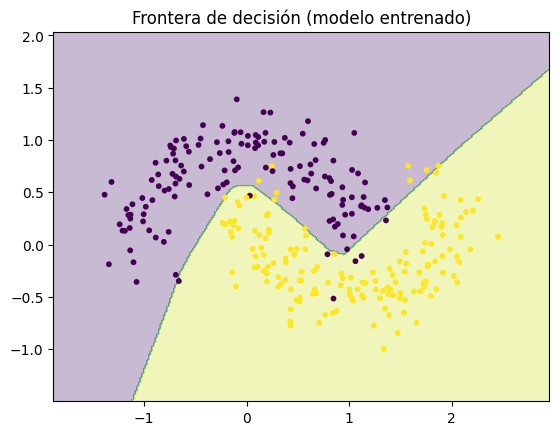

In [9]:
# Malla para visualizar la frontera de decisión
xx, yy = np.meshgrid(
    np.linspace(X[:,0].min()-0.5, X[:,0].max()+0.5, 300),
    np.linspace(X[:,1].min()-0.5, X[:,1].max()+0.5, 300)
)
grid = torch.tensor(np.c_[xx.ravel(), yy.ravel()], dtype=torch.float32)

with torch.no_grad():
    Z = net(grid).argmax(dim=1).reshape(xx.shape).numpy()

plt.contourf(xx, yy, Z, alpha=0.3)
plt.scatter(X_val[:,0], X_val[:,1], c=y_val, s=10)
plt.title("Frontera de decisión (modelo entrenado)")


# Control exlpícito de la inicialización

In [ ]:
def init_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.normal_(m.weight, mean=0.0, std=0.1)
        nn.init.zeros_(m.bias)

net = MLP()
net.apply(init_weights)  # aplica tu init definida arriba
